In [23]:
from scipy import signal as sg
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
import pandas as pd

In [24]:
#Metti nella stessa cartella di questo notebook il file wav da analizzare
files = glob.glob("*.wav")
file = files[0]
print(file)

20211121_050319_192.wav


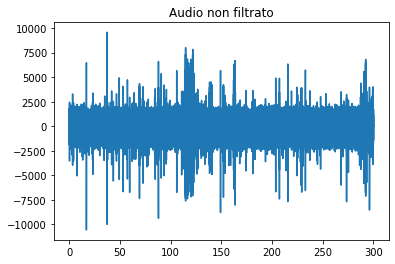

In [25]:
# Importazione file audio wavù
sr,wav = wavfile.read(file)
N = wav.shape[0]
t = np.arange(N) / sr
plt.plot(t, wav)
plt.title("Audio non filtrato")
plt.show()

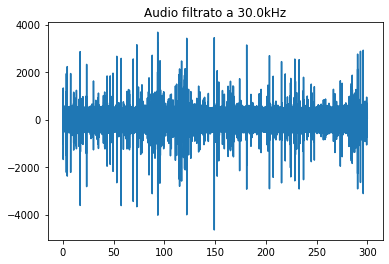

In [26]:
# Filtraggio passa alto
low_band = 30e3
filter = sg.butter(4, low_band, btype='highpass', analog=False, output='sos', fs=sr)
wav = sg.sosfilt(filter, wav)
plt.plot(t, wav)
plt.title(f"Audio filtrato a {low_band//1e3}kHz")
plt.show()

In [34]:
chunk_length = 1  #sec chunk
chunk_size = int(chunk_length*sr)   #numero campioni chunk
chunk_step = chunk_size#//2  #decommentare per avere i chunk sovrapposti (overlappati) di mezzo chunk (se ne otterranno il doppio)
wav_chunks = []
time_chunks = []
for i in range(0, N, chunk_step):
    time_chunks.append(t[i: i+chunk_size])
    wav_chunks.append(wav[i: i+chunk_size])
print(len(wav_chunks))

301


In [35]:
#EXPORT 1
export_1 = {
    "filename" : file,
    "threshold" : 4.5,
    "distance" : 50e-3*sr,
    "min_peaks_num" : 5,
    "min_std_chi_test" : 4000,
}


In [46]:
threshold = 5 #snr
distance = 50e-3*sr
min_peaks_num = 5*chunk_length
min_std_chi_test = 4000

columns = ["initial_time", "noise_level", "peaks_num", "peaks_true", "peaks_offsets",
           "peaks_snrs", "peaks_dists", "dists_min", "dists_max", "dists_mean", "dists_std", "chi_test", "chi_pval(%)"]
data_dict = {i:[] for i in columns}

for n, wav_chunk in enumerate(wav_chunks):

    data_dict["initial_time"].append(n)

    ss = wav_chunk - np.mean(wav_chunk)
    nn = np.sqrt(np.mean(np.square(ss)))
    data_dict["noise_level"].append(nn)
    snr = np.abs(ss) / nn

    peaks, props = sg.find_peaks(snr, height=threshold, distance=distance)

    peaks_num = peaks.shape[0]
    peaks_true = peaks_num >= min_peaks_num
    data_dict["peaks_num"].append(peaks_num)
    data_dict["peaks_true"].append(peaks_true)
    data_dict["peaks_offsets"].append(peaks)

    if peaks_true:
        data_dict["peaks_snrs"].append(props["peak_heights"])

        peaks_dist = np.diff(peaks)
        data_dict["peaks_dists"].append(peaks_dist)
        
        std = np.std(peaks_dist)
        mean = np.mean(peaks_dist)
        data_dict["dists_min"].append(np.min(peaks_dist))
        data_dict["dists_max"].append(np.max(peaks_dist))
        data_dict["dists_mean"].append(mean)
        data_dict["dists_std"].append(std)

        chi = (std ** 2) * (peaks_num - 1) / (min_std_chi_test ** 2)
        pval = st.chi2.sf(chi, (peaks_num - 1))
        data_dict["chi_test"].append(chi)
        data_dict["chi_pval(%)"].append(pval*100)

    else:
        for key in columns[5:]:
            data_dict[key].append(None)

df = pd.DataFrame(data=data_dict)
df_true = df.loc[df.peaks_true].reset_index()
df_true


,index,initial_time,noise_level,peaks_num,peaks_true,peaks_offsets,peaks_snrs,peaks_dists,dists_min,dists_max,dists_mean,dists_std,chi_test,chi_pval(%)
0,93,93,145.38,10,True,"[2821, 23528, 45464, 66687, 88707, 109631, 126...","[8.292045586742567, 6.522067238573658, 6.55216...","[20707, 21936, 21223, 22020, 20924, 16566, 177...",16566.0,22020.0,19975.11,1879.68,1.99,9.92e+01
1,95,95,137.41,10,True,"[62670, 77042, 90222, 102027, 113519, 124480, ...","[11.953752677285708, 14.173353110702493, 15.37...","[14372, 13180, 11805, 11492, 10961, 10678, 113...",10678.0,18133.0,12980.11,2296.39,2.97,9.66e+01
2,97,97,122.88,7,True,"[256, 10023, 20854, 34918, 63979, 127528, 179888]","[6.639349438758772, 8.100040271098964, 8.85637...","[9767, 10831, 14064, 29061, 63549, 52360]",9767.0,63549.0,29938.67,21044.18,166.07,3.06e-31
3,99,99,124.00,9,True,"[6368, 18713, 29926, 41003, 52547, 65135, 8076...","[6.233831043098816, 8.999125796577214, 8.89854...","[12345, 11213, 11077, 11544, 12588, 15632, 185...",11077.0,18780.0,13961.38,3019.40,4.56,8.04e+01
4,116,116,188.34,5,True,"[38415, 90381, 101139, 127779, 190294]","[6.254246953158632, 5.6940687324980335, 5.7357...","[51966, 10758, 26640, 62515]",10758.0,62515.0,37969.75,20415.72,104.20,1.25e-19
5,119,119,157.31,5,True,"[114372, 151730, 162559, 176984, 187057]","[8.065623926967275, 7.34795912466373, 11.86613...","[37358, 10829, 14425, 10073]",10073.0,37358.0,18171.25,11198.84,31.35,2.59e-04
6,120,120,171.43,9,True,"[7289, 48097, 59107, 74310, 90999, 103356, 123...","[8.246436459462892, 7.2624523118513045, 6.5116...","[40808, 11010, 15203, 16689, 12357, 20315, 177...",11010.0,40808.0,19493.50,8752.04,38.30,6.63e-04
7,165,165,151.53,5,True,"[33446, 53229, 78368, 104758, 128659]","[10.657681663386212, 6.978572344077681, 6.8902...","[19783, 25139, 26390, 23901]",19783.0,26390.0,23803.25,2482.31,1.54,8.19e+01
8,167,167,138.45,6,True,"[5855, 33952, 55922, 81168, 100219, 148080]","[6.187824452917903, 7.697103740100978, 9.25418...","[28097, 21970, 25246, 19051, 47861]",19051.0,47861.0,28445.00,10173.58,32.34,5.08e-04
9,282,282,134.51,5,True,"[7216, 131405, 143453, 156271, 169661]","[8.397676984560949, 5.2741051076367675, 6.2937...","[124189, 12048, 12818, 13390]",12048.0,124189.0,40611.25,48255.99,582.16,1.12e-122
